# Split Learning—Bank Marketing

>The following codes are demos only. It's **NOT for production** due to system security concerns, please **DO NOT** use it directly in production.

In this tutorial, we will use the bank's marketing model as an example to show how to accomplish split learning in vertical scenarios under the SecretFlow framework.
SecretFlow provides a user-friendly Api that makes it easy to apply your Keras model or PyTorch model to split learning scenarios to complete joint modeling tasks for vertical scenarios.

In this tutorial we will show you how to turn your existing 'Keras' model into a split learning model under Secretflow to complete federated multi-party modeling tasks.

## What is Split Learning？

The core idea of split learning is to split the network structure. Each device (silo) retains only a part of the network structure, and the sub-network structure of all devices is combined together to form a complete network model. 
In the training process, different devices (silos) only perform forward or reverse calculation on the local network structure, and transfer the calculation results to the next device. Multiple devices complete the training through joint model until convergence.

 <img alt="split_learning_tutorial.png" src="resources/split_learning_tutorial.png" width="600">  


**Alice**：have *data\_alice*，*model\_base\_alice*  
**Bob**: have *data\_bob*，*model\_base\_bob*，*model\_fuse*  

1. **Alice** uses its data to get *hidden0* through *model\_base\_Alice* and send it to Bob. 
2. **Bob** gets *hidden1* with its data through *model\_base\_bob*.
3. *hidden\_0* and *hidden\_1* are input to the *AggLayer* for aggregation, and the aggregated *hidden\_merge* is the output.
4. **Bob** input *hidden\_merge* to *model\_fuse*, get the gradient with *label* and send it back.
5. The gradient is split into two parts *g\_0*, *g\_1* through *AggLayer*, which are sent to **Alice** and **Bob** respectively.
6. Then **Alice** and **Bob** update their local base net with *g\_0* or *g\_1*.


## Task

Marketing is the banking industry in the ever-changing market environment, to meet the needs of customers, to achieve business objectives of the overall operation and sales activities. In the current environment of big data, data analysis provides a more effective analysis means for the banking industry. Customer demand analysis, understanding of target market trends and more macro market strategies can provide the basis and direction.  
  
The data from [kaggle](https://www.kaggle.com/janiobachmann/bank-marketing-dataset) is a set of classic marketing data bank, is a Portuguese bank agency telephone direct marketing activities, The target variable is whether the customer subscribes to deposit product.

## Data

1. The total sample size was 11162, including 8929 training set and 2233 test set.
2. Feature dim is 16, target is binary classification.
3. We have cut the data in advance. Alice holds the 4-dimensional basic attribute features, Bob holds the 12-dimensional bank transaction features, and only Alice holds the corresponding label.

Let's start by looking at what our bank's marketing data look like?  

The original data is divided into Bank Alice and Bank Bob, which stores in Alice and Bob respectively. Here, CSV is the original data that has only been separated without pre-processing, we will use `secretflow preprocess` for FedData preprocess.

### prepare data drj

In [3]:
import pandas as pd
from secretflow.utils.simulation.datasets import dataset

df = pd.read_csv(dataset('bank_marketing'), sep=';')
data =df.iloc[:, 0:16]
label=df['y']

We assume that Alice is a new bank, and they only have the basic information of the user and purchased the label of financial products from other bank.

In [4]:
alice_columns = ["age", "job", "marital", "education", "y"]
bob_colomns = [
        "default",
        "balance",
        "housing",
        "loan",
        "contact",
        "day",
        "month",
        "duration",
        "campaign",
        "pdays",
        "previous",
        "poutcome",
    ]
alice_data = df[alice_columns]
alice_data

,age,job,marital,education,y
0,30,unemployed,married,primary,no
1,33,services,married,secondary,no
2,35,management,single,tertiary,no
3,30,management,married,tertiary,no
4,59,blue-collar,married,secondary,no
...,...,...,...,...,...
4516,33,services,married,secondary,no
4517,57,self-employed,married,tertiary,no
4518,57,technician,married,secondary,no
4519,28,blue-collar,married,secondary,no


Bob is an old bank, they have the user's account balance, house, loan, and recent marketing feedback.

In [5]:
bob_data = df[bob_colomns]
bob_data

,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown
1,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure
2,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure
3,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown
4,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
4516,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown
4517,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown
4518,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown
4519,no,1137,no,no,cellular,6,feb,129,4,211,3,other


Next, we perform data preprocessing on the `VDataFrame`.   
We use LabelEncoder and MinMaxScaler as examples. These two preprocessing functions have corresponding concepts in SkLearn, and their usage methods are similar to those in **sklearn**.

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [7]:
# 类别类编码
encoder = LabelEncoder()
data['job'] = encoder.fit_transform(data['job'])
data['marital'] = encoder.fit_transform(data['marital'])
data['education'] = encoder.fit_transform(data['education'])
data['default'] = encoder.fit_transform(data['default'])
data['housing'] = encoder.fit_transform(data['housing'])
data['loan'] = encoder.fit_transform(data['loan'])
data['contact'] = encoder.fit_transform(data['contact'])
data['poutcome'] = encoder.fit_transform(data['poutcome'])
data['month'] = encoder.fit_transform(data['month'])
label = encoder.fit_transform(label)

print(type(data['job'].iloc[0]))

<class 'numpy.int64'>


In [40]:
# 打印data 的数据类型
print(f"label= {type(label)},\ndata = {type(data)}")
data.describe()
print(data.dtypes)

label= <class 'secretflow.data.vertical.dataframe.VDataFrame'>,
data = <class 'secretflow.data.vertical.dataframe.VDataFrame'>


AttributeError: 'VDataFrame' object has no attribute 'describe'

Standardize data via MinMaxScaler

In [9]:
# 对数据进行normalize
scaler = MinMaxScaler()

data = scaler.fit_transform(data)

# data.astype('float32')
# print('type(data)=', type(data))
# print(data.columns)
# print(data['job'].loc[0:0])

Next we divide the data set into train-set and test-set.

In [13]:
# 划分训练集和测试集，并且将数据划分给alice和bob
# from secretflow.data.split import train_test_split
from sklearn.model_selection import train_test_split
import numpy as np 

random_state = 1234
train_data, test_data = train_test_split(
    data, train_size=0.8, random_state=random_state
)
train_label, test_label = train_test_split(
    label, train_size=0.8, random_state=random_state
)


print(train_label.dtype)
print(train_label[0:10])
print(train_label.shape)
print(train_data.shape)


train_data_alice = np.hstack((train_data[:,[0,1,2,3]], train_label.reshape(-1,1)))
train_data_bob = train_data[:,[4,5,6,7,8,9,10,11,12,13,14,15]]
test_data_alice = np.hstack((test_data[:,[0,1,2,3]], test_label.reshape(-1,1)))
test_data_bob = test_data[:,[4,5,6,7,8,9,10,11,12,13,14,15]]

# bob_data = train_data[:,[0,1,2,3,16]]

int64
[0 0 1 0 0 0 0 0 0 0]
(3616,)
(3616, 16)


**Summary:** At this stage, we have finished defining `federated tables`, performing `data preprocessing`, and partitioning the `training set` and `test set`.
The secretFlow framework defines a set of operations to be built on the federated table (which is the logical counterpart of `pandas.DataFrame`). The secretflow framework defines a set of operations to be built on the federated table (its logical counterpart is `sklearn`) Refer to our documentation and API introduction to learn more about other features.

In [11]:
# 存储数据：
# train_data.to_csv('train_data.csv', index=False)
# test_data.to_csv('test_data.csv', index=False)
# train_label.to_csv('train_label.csv', index=False)
# test_label.to_csv('test_label.csv', index=False)
data_route = '/home/dengruijun/data/FinTech/DATASET/kaggle-dataset/bank/bank-secretflow/'
# 划分alice 和 bob 的数据
pd.DataFrame(train_data_alice,columns=alice_columns).to_csv(data_route+'train_data_alice.csv', index=False)
pd.DataFrame(train_data_bob,columns=bob_colomns).to_csv(data_route+'train_data_bob.csv', index=False)
pd.DataFrame(test_data_alice,columns=alice_columns).to_csv(data_route+'test_data_alice.csv', index=False)
pd.DataFrame(test_data_bob,columns=bob_colomns).to_csv(data_route+'test_data_bob.csv', index=False)
print("saving data done!")

# 打印数据出来看看
! head /home/dengruijun/data/FinTech/DATASET/kaggle-dataset/bank/bank-secretflow/train_data_alice.csv

saving data done!


/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


age,job,marital,education,y
0.23529411764705876,0.09090909090909091,0.5,0.3333333333333333,0.0
0.1764705882352941,0.36363636363636365,0.5,0.3333333333333333,0.0
0.4117647058823529,0.2727272727272727,1.0,0.6666666666666666,1.0
0.5735294117647058,0.4545454545454546,0.5,0.3333333333333333,0.0
0.48529411764705876,0.8181818181818182,0.5,0.3333333333333333,0.0
0.27941176470588236,0.8181818181818182,1.0,0.3333333333333333,0.0
0.1764705882352941,0.6363636363636364,1.0,0.3333333333333333,0.0
0.16176470588235292,0.09090909090909091,1.0,0.3333333333333333,0.0
0.32352941176470584,0.36363636363636365,0.5,0.6666666666666666,0.0


In [14]:
# 构造data builder
import torch
from torch.utils.data import DataLoader, Dataset

# transform DataFrame to Dataset

class AliceDataset(Dataset):
    def __init__(self, df, label_df, vocab_dir):
        # self.label_df = df['y']
        # self.feature_df = df.drop(columns=['y'])
        self.label_df = label_df
        self.feature_df = df

    def __getitem__(self, index):
        X = torch.tensor(self.feature_df.iloc[index]) 
        y = torch.tensor(int(self.label_df.iloc[index]))

        return X,y

    def __len__(self):
        return len(self.label_df)


class BobDataset(Dataset):
    def __init__(self, df, vocab_dir):
        self.feature_df = df

    def __getitem__(self, index):
        X = torch.tensor(self.feature_df.iloc[index])
        return X

    def __len__(self):
        return len(self.feature_df)

def create_dataset_builder_alice(batch_size=32):
    def dataset_builder(x):
        data_set = AliceDataset(x[0],x[1],data_route)
        dataloader = DataLoader(
            dataset=data_set,
            batch_size=batch_size,
        )
        return dataloader

    return dataset_builder

def create_dataset_builder_bob(batch_size=32):
    def dataset_builder(x):
        data_set = BobDataset(x[0],data_route)
        dataloader = DataLoader(
            dataset=data_set,
            batch_size=batch_size,
        )
        return dataloader

    return dataset_builder

batch_size = 32
dataset_buidler_dict = {
    alice: create_dataset_builder_alice(batch_size=batch_size),
    bob: create_dataset_builder_bob(batch_size=batch_size),
}

In [15]:
# 查看一些信息：
train_data_alice.shape[0]

3616

## Create Secretflow Environment

Create 2 entities in the Secretflow environment [Alice, Bob]  
Where 'Alice' and 'Bob' are two `PYU`.  
Once you've constructed the two objects, you can happily start Splitting Learning.

In [1]:
%load_ext autoreload  
%autoreload 2

# import os
# os.environ['NUMEXPR_MAX_THREADS'] = '48'
import secretflow as sf
import matplotlib.pyplot as plt

# import ray
# ray.init(log_to_driver=True)
sf.shutdown() # incase of re-run
print('ok1')
# sf.init(['alice', 'bob'])
sf.init(['alice', 'bob','charlie'], address='local')
print('ok2')
alice, bob, charlie= sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')
print('ok3')

spu = sf.SPU(sf.utils.testing.cluster_def(['alice', 'bob','charlie']))

/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-11 06:35:16,894	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


ok1


/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-11-11 06:35:26,957	INFO worker.py:1724 -- Started a local Ray instance.


ok2
ok3


In [2]:
# from secretflow.data.split import train_test_split
# from secretflow.ml.nn import SLModel

## Prepare Data

**Build Federated Table**


Federated table is a virtual concept that cross multiple parties, We define `VDataFrame` for vertical setting
.  

1. The data of all parties in a federated table is stored locally and is not allowed to go out of the domain.

2. No one has access to data store except the party that owns the data.

3. Any operation performed on the federated table is scheduled by the driver to each worker, and the execution instructions are delivered layer by layer until the Python runtime of the specific worker. The framework ensures that only the worker with `worker.device` equal to the `Object.device` can operate on the data.

4. Federated tables are designed for managing and manipulating multi-party data from a central perspective.

5. Interfaces to `Federated Tables` are aligned to `pandas.DataFrame` to reduce the cost of multi-party data operations.

6. The SecretFlow framework provides Plain&Ciphertext hybrid programming capabilities. Vertical federated tables are built using `SPU`, and `MPC-PSI` is used to safely get intersection and align data from all parties.

<img alt="vdataframe.png" src="resources/vdataframe.png" width="600">  



VDataFrame provides `read_csv` interface similar to pandas, the difference is that `secretflow.read_csv` receives a dictionary that defines the path of data for both parties. We can use `secretflow.vertical.read_csv` to build the `VDataFrame`.
```
read_csv(file_dict,delimiter,ppu,keys,drop_key)
    filepath: Path of the participant file. The address can be a relative or absolute path to a local file
    spu: SPU Device for PSI; If this parameter is not specified, data must be prealigned
    keys: Key for intersection.
```

Create spu object

In [3]:
# spu = sf.SPU(sf.utils.testing.cluster_def(['alice', 'bob']))

In [4]:
# 分割alice和bob的数据集的schema（不是数据集本身）

from secretflow.utils.simulation.datasets import load_bank_marketing

# Alice has the first four features,
# while bob has the left features
data = load_bank_marketing(parts={alice: (0, 4), bob: (4, 12), charlie:(12,16)}, axis=1)
# Alice holds the label.
label = load_bank_marketing(parts={alice: (16, 17)}, axis=1)


INFO:root:Create proxy actor <class 'secretflow.data.core.agent.PartitionAgent'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.data.core.agent.PartitionAgent'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.data.core.agent.PartitionAgent'> with party charlie.
INFO:root:Create proxy actor <class 'secretflow.data.core.agent.PartitionAgent'> with party alice.


`data` is a vertically federated table. It only has the `Schema` of all the data globally.

Let's examine the data management of `VDF` more closely.

As shown in the example, the `age` field belongs to `Alice`, so the corresponding column can be obtained from `Alice`'s partition. However, if `Bob` tries to obtain the `age` field, a `KeyError` error will be reported.

We have a concept called Partition, which is a defined data fragment. Each partition has its own device to which it belongs, and only the device to which it belongs can operate on its data.

In [5]:
data['age'].partitions[alice].data

# num_samples=train_data.values.partition_shape()[alice][0],

In [6]:
# You can uncomment this and you will get a KeyError.
# data['age'].partitions[bob]

Next, we perform data preprocessing on the `VDataFrame`.   
We use LabelEncoder and MinMaxScaler as examples. These two preprocessing functions have corresponding concepts in SkLearn, and their usage methods are similar to those in **sklearn**.

In [7]:
from secretflow.preprocessing.scaler import MinMaxScaler
from secretflow.preprocessing.encoder import LabelEncoder

In [8]:
# 类别类编码
encoder = LabelEncoder()
data['job'] = encoder.fit_transform(data['job'])
data['marital'] = encoder.fit_transform(data['marital'])
data['education'] = encoder.fit_transform(data['education'])
data['default'] = encoder.fit_transform(data['default'])
data['housing'] = encoder.fit_transform(data['housing'])
data['loan'] = encoder.fit_transform(data['loan'])
data['contact'] = encoder.fit_transform(data['contact'])
data['poutcome'] = encoder.fit_transform(data['poutcome'])
data['month'] = encoder.fit_transform(data['month'])
label = encoder.fit_transform(label)

In [9]:
print(f"label= {type(label)},\ndata = {type(data)}")

label= <class 'secretflow.data.vertical.dataframe.VDataFrame'>,
data = <class 'secretflow.data.vertical.dataframe.VDataFrame'>


Standardize data via MinMaxScaler

In [10]:
# 归一化、 打印数据信息 
scaler = MinMaxScaler()

data = scaler.fit_transform(data)
# data.astype('float32')
# print('type(data)=', type(data))
print(data.columns)
# print(data['job'].loc[0:0])

# print(data[alice].shape)
print(data)
print(data.partitions)
print(data.columns) # alice和bob的数据集的列名（总的列表）
print(data.partition_columns) # alice和bob的数据集的列名（分别）
print("data.dtypes: ",data.dtypes)
print('label.dtypes: ', label.dtypes)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
VDataFrame(partitions={PYURuntime(alice): <secretflow.data.core.partition.Partition object at 0x7f7020659510>, PYURuntime(bob): <secretflow.data.core.partition.Partition object at 0x7f70387979a0>, PYURuntime(charlie): <secretflow.data.core.partition.Partition object at 0x7f7020681810>}, aligned=True)
{PYURuntime(alice): <secretflow.data.core.partition.Partition object at 0x7f7020659510>, PYURuntime(bob): <secretflow.data.core.partition.Partition object at 0x7f70387979a0>, PYURuntime(charlie): <secretflow.data.core.partition.Partition object at 0x7f7020681810>}
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
{PYURuntime(alice): ['age', 'job', 'marital', 'education'], PYURuntime(bob): ['default', 'balance', 'hous

(PartitionAgent pid=344541) /home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
(PartitionAgent pid=344541)   warnings.warn(


In [11]:
#转换dtypes

# float64 to float32
float64_colomns = data.select_dtypes(include=['float64']).columns
print(float64_colomns)
data[float64_colomns] = data[float64_colomns].astype('float32')

label=label.astype('float32')

print("data.dtypes: ",data.dtypes)
print("label.dtypes: ",label.dtypes)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
data.dtypes:  {'age': dtype('float32'), 'job': dtype('float32'), 'marital': dtype('float32'), 'education': dtype('float32'), 'default': dtype('float32'), 'balance': dtype('float32'), 'housing': dtype('float32'), 'loan': dtype('float32'), 'contact': dtype('float32'), 'day': dtype('float32'), 'month': dtype('float32'), 'duration': dtype('float32'), 'campaign': dtype('float32'), 'pdays': dtype('float32'), 'previous': dtype('float32'), 'poutcome': dtype('float32')}
label.dtypes:  {'y': dtype('float32')}


Next we divide the data set into train-set and test-set.

In [12]:
from secretflow.data.split import train_test_split

random_state = 1234
train_data, test_data = train_test_split(
    data, train_size=0.8, random_state=random_state
)
train_label, test_label = train_test_split(
    label, train_size=0.8, random_state=random_state
)

print(train_data.values.partition_shape()[alice][0],) # 总的样本数目
# 存储数据：
# train_data.to_csv('train_data.csv', index=False)

3616


**Summary:** At this stage, we have finished defining `federated tables`, performing `data preprocessing`, and partitioning the `training set` and `test set`.
The secretFlow framework defines a set of operations to be built on the federated table (which is the logical counterpart of `pandas.DataFrame`). The secretflow framework defines a set of operations to be built on the federated table (its logical counterpart is `sklearn`) Refer to our documentation and API introduction to learn more about other features.

## Introduce Model

**local version**: 
For this task, a simple DNN can be trained to take in 16-dimensional features, process them through a neural network, and output the probability of positive and negative samples.


**Federate version**:  

* Alice:  

    - base_net: Input 4-dimensional feature and go through a DNN network to get hidden.  
    
    - fuse_net: Receive hidden features calculated by Alice and Bob, input them to fusenet for feature fusion, and complete the forward process and backward process.  
    
* Bob:  

    - base_net: Input 12-dimensional features, get hidden through a DNN network, and then send hidden to Alice to complete the following operation.  


### Define Model

Next, we will start creating the federated model.  

We have defined the SLTFModel and SLTorchModel, which are used to build split learning for vertically partitioned data. We have also created a simple and easy-to-use extensible interface, allowing you to easily transform your existing model into an SF-Model and perform vertically partitioned federated modeling.

Split learning is to break up a model so that one part is executed locally on the data and the other part is executed on the label side.
First let's define the locally executed model -- base_model.

In [13]:
# torch相关
from secretflow.ml.nn.core.torch import (
    metric_wrapper,
    optim_wrapper,
    BaseModule,
    TorchModel,
)
from secretflow.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator
from secretflow.utils.simulation.datasets import load_mnist
from torch import nn, optim
from torch.nn import functional as F
import torch

from secretflow.ml.nn import SLModel

In [14]:
class DenseNet(nn.Module):
    def __init__(self,input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, output_dim)
        self.relu2 = nn.ReLU()

        self.output_num_value = output_dim
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        return x

    def output_num(self):
        return self.output_num_value

In [15]:
# prepare model
hidden_size = 64

def model_base_alice_fn():
    def create_model():
        return DenseNet(input_dim=4, output_dim=hidden_size)
    return create_model

def model_base_bob_fn():
    def create_model():
        return DenseNet(input_dim=8, output_dim=hidden_size)
    return create_model

def model_base_charlie_fn():
    def create_model():
        return DenseNet(input_dim=4, output_dim=hidden_size)
    return create_model

model_base_alice = TorchModel(
    model_fn=model_base_alice_fn(),
    loss_fn=nn.BCELoss,
    optim_fn = optim_wrapper(optim.Adam),
    metrics = [
    metric_wrapper(Accuracy, task='binary',),
    metric_wrapper(Precision, task='binary',),
    ],
    # input_dim=4, output_dim=hidden_size,
    )

model_base_bob = TorchModel(
    model_fn=model_base_bob_fn(),
    loss_fn=nn.BCELoss,
    optim_fn = optim_wrapper(optim.Adam),
    metrics = [
    metric_wrapper(Accuracy, task='binary',),
    metric_wrapper(Precision, task='binary',),
    ],
    # input_dim=12, output_dim=hidden_size,
    )

model_base_charlie = TorchModel(
    model_fn=model_base_charlie_fn(),
    loss_fn=nn.BCELoss,
    optim_fn = optim_wrapper(optim.Adam),
    metrics = [
    metric_wrapper(Accuracy, task='binary',),
    metric_wrapper(Precision, task='binary',),
    ],
    # input_dim=12, output_dim=hidden_size,
    )

We use create_base_model to create their base models for 'Alice' and 'Bob', respectively.

Next we define the side with the label, or the server-side model -- fuse_model
In the definition of fuse_model, we need to correctly define `loss`, `optimizer`, and `metrics`. This is compatible with all configurations of your existing Keras model.

In [16]:
class DenseFuseNet(BaseModule):
    def __init__(self,input_dim, output_dim, party_num):
        super().__init__()

        # layers = []
        # for i in range(party_num):
            # layers.append(nn.Linear(input_dim, output_dim))
        self.total_input_dim = input_dim * party_num
        self.fc1 = nn.Linear(self.total_input_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        merged_x = torch.cat(x,dim=1)
        x = self.fc1(merged_x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [17]:
# model_fuse = DenseFuseNet(input_dim=64, output_dim=1, party_num=2)
def model_fuse_fn():
    def create_model():
        return DenseFuseNet(input_dim=64, output_dim=1, party_num=3)
    return create_model

model_fuse = TorchModel(
    model_fn=model_fuse_fn(),
    loss_fn=nn.BCELoss,
    optim_fn = optim_wrapper(optim.Adam),
    metrics = [
    metric_wrapper(Accuracy, task='binary',),
    metric_wrapper(Precision, task='binary',),
    ],
    # input_dim=64, output_dim=1, party_num=2,
    )

### Create Split Learning Model  
Secretflow provides the split learning model `SLModel`.  
To initial SLModel only need 3 parameters.  

* base_model_dict: A dictionary needs to be passed in all clients participating in the training along with base_model mappings  
* device_y: PYU, which device has label  
* model_fuse: The fusion model  

Define base_model_dict.  
```python
base_model_dict:Dict[PYU,model_fn]
```

In [18]:
base_model_dict = {alice: model_base_alice, bob: model_base_bob, charlie: model_base_charlie}

In [19]:
# 用了差分隐私机制 这块纯差分隐私的内容，没有训练相关的
from secretflow.security.privacy import DPStrategy, LabelDP
# from secretflow.security.privacy.mechanism.tensorflow import GaussianEmbeddingDP
from secretflow.security.privacy.mechanism.torch import GaussianEmbeddingDP 

# Define DP operations
train_batch_size = 128
gaussian_embedding_dp = GaussianEmbeddingDP(
    noise_multiplier=0.5, # epsilon for pure DP
    l2_norm_clip=1.0, # clipping norm to the parameters or gradients
    batch_size=train_batch_size,
    # num_samples=train_data.values.partition_shape()[alice][0],
    num_samples=train_data.values.partition_shape()[alice][0],
    # num_samples = train_data_alice.shape[0], # 总的样本数目

    is_secure_generator=False, # whether use the secure generator to generate noise
)

# Define DP strategy
label_dp = LabelDP(eps=64.0)
dp_strategy_alice = DPStrategy(label_dp=label_dp)
dp_strategy_bob = DPStrategy(embedding_dp=gaussian_embedding_dp)
dp_strategy_dict = {alice: dp_strategy_alice, bob: dp_strategy_bob}
dp_spent_step_freq = 10

In [20]:
# SL框架
sl_model = SLModel(
    base_model_dict=base_model_dict, # Basemodel dictionary, key is PYU, value is the Basemodel defined by party.
    device_y=alice, # Define which model have label.
    model_fuse=model_fuse, # Fuse model definition.
    # dp_strategy_dict=dp_strategy_dict, # 不使用DP
    backend='torch', # name of backend engine, tensorflow or torch, default tensorflow
)

INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party charlie.


In [21]:
# 本来有的被我注释了
sf.reveal(test_data.partitions[alice].data), sf.reveal(test_label.partitions[alice].data)

(          age       job  marital  education
 0    0.279412  0.181818      0.5   0.333333
 1    0.176471  0.636364      1.0   0.333333
 2    0.264706  0.000000      0.5   0.666667
 3    0.338235  0.000000      0.5   0.333333
 4    0.132353  0.909091      1.0   0.333333
 ..        ...       ...      ...        ...
 900  0.264706  0.818182      1.0   0.333333
 901  0.544118  0.090909      0.0   0.000000
 902  0.455882  0.090909      0.5   0.000000
 903  0.485294  0.090909      0.5   0.333333
 904  0.455882  0.636364      0.5   0.333333
 
 [905 rows x 4 columns],
        y
 0    0.0
 1    0.0
 2    0.0
 3    0.0
 4    0.0
 ..   ...
 900  0.0
 901  0.0
 902  0.0
 903  0.0
 904  0.0
 
 [905 rows x 1 columns])

In [22]:
# 本来有的被我注释了
# sf.reveal(train_data.partitions[alice].data), sf.reveal(train_label.partitions[alice].data)

In [23]:
sf.reveal(test_data.partitions[bob].data)

,default,balance,housing,loan,contact,day,month,duration
0,0.0,0.046577,0.0,1.0,0.0,0.466667,0.727273,0.017544
1,0.0,0.072254,0.0,0.0,0.0,0.933333,0.090909,0.104270
2,0.0,0.055221,0.0,0.0,0.0,0.333333,0.090909,0.108242
3,0.0,0.044469,0.0,0.0,1.0,0.600000,0.545455,0.121152
4,0.0,0.044684,0.0,0.0,0.0,0.366667,0.090909,0.038067
...,...,...,...,...,...,...,...,...
900,1.0,0.049503,0.0,0.0,1.0,0.266667,0.545455,0.072493
901,0.0,0.085019,0.0,0.0,1.0,0.266667,0.545455,0.137372
902,0.0,0.044456,0.0,0.0,0.0,0.600000,0.090909,0.063224
903,0.0,0.059462,1.0,0.0,0.0,0.400000,0.727273,0.119497


In [24]:
# 提取数据集&模型 # drj自定义数据集
# from secretflow.data.vertical import read_csv
# vdf_train = read_csv({
#     alice: data_route+'train_data_alice.csv',
#     bob: data_route+'train_data_bob.csv',
# })
# train_label = vdf_train['y']
# train_data = vdf_train.drop(columns=['y'])

# vdf_test = read_csv({
#     alice: data_route+'test_data_alice.csv',
#     bob: data_route+'test_data_bob.csv',
# })
# test_label = vdf_test['y']
# test_data = vdf_test.drop(columns=['y'])


In [25]:
# 训练模型
history = sl_model.fit(
    train_data, # X
    train_label, # y
    validation_data=(train_data, train_label), # 默认为None
    # validation_data=(test_data, test_label),
    epochs=10, # Number of epochs to train the model
    batch_size=train_batch_size, # Number of samples per gradient update.
    shuffle=True, # Whether shuffle dataset or not
    # verbose=1,
    validation_freq=1, # pecifies how many training epochs to run before a new validation run is performed
    # dp_spent_step_freq=dp_spent_step_freq, # specifies how many training steps to check the budget of dp
    # dataset_builder=dataset_buidler_dict, # Callable function, its input is x or [x, y] if y is set, it should return a dataset.
)

INFO:root:SL Train Params: {'self': <secretflow.ml.nn.sl.sl_model.SLModel object at 0x7f7020680be0>, 'x': VDataFrame(partitions={PYURuntime(alice): <secretflow.data.core.partition.Partition object at 0x7f7020682920>, PYURuntime(bob): <secretflow.data.core.partition.Partition object at 0x7f702058f1c0>, PYURuntime(charlie): <secretflow.data.core.partition.Partition object at 0x7f702058f670>}, aligned=True), 'y': VDataFrame(partitions={PYURuntime(alice): <secretflow.data.core.partition.Partition object at 0x7f702058faf0>}, aligned=True), 'batch_size': 128, 'epochs': 10, 'verbose': 1, 'callbacks': None, 'validation_data': (VDataFrame(partitions={PYURuntime(alice): <secretflow.data.core.partition.Partition object at 0x7f7020682920>, PYURuntime(bob): <secretflow.data.core.partition.Partition object at 0x7f702058f1c0>, PYURuntime(charlie): <secretflow.data.core.partition.Partition object at 0x7f702058f670>}, aligned=True), VDataFrame(partitions={PYURuntime(alice): <secretflow.data.core.partit

Epoch 1/10


Train Processing: :   0%|          | 0/29 [00:03<?, ?it/s]2024-11-11 06:36:06,712	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::PYUSLTorchModel.set_gradients() (pid=344944, ip=10.176.22.34, actor_id=3357336564dbadeba5d72a7d01000000, repr=<secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel object at 0x7efb9bbacc10>)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.RayTaskError: ray::_run() (pid=341716, ip=10.176.22.34)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/device/pyu.py", line 156, in _run
    return fn(*args, **kwargs)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/ml/nn/sl/agglayer/agg_layer.py", line 279, in split_to_parties
    assert len(data) == sum(
AssertionError: data length in backward = 3 is not consistent with basenet need = 192,
2024-11-11 06:36:06,716	ERROR worker.py:405 --

Epoch 2/10


2024-11-11 06:36:11,573	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::PYUSLTorchModel.set_gradients() (pid=344944, ip=10.176.22.34, actor_id=3357336564dbadeba5d72a7d01000000, repr=<secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel object at 0x7efb9bbacc10>)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.RayTaskError: ray::_run() (pid=341714, ip=10.176.22.34)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/device/pyu.py", line 156, in _run
    return fn(*args, **kwargs)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/ml/nn/sl/agglayer/agg_layer.py", line 279, in split_to_parties
    assert len(data) == sum(
AssertionError: data length in backward = 3 is not consistent with basenet need = 192,
2024-11-11 06:36:11,577	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRO

Epoch 3/10


2024-11-11 06:36:13,528	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::PYUSLTorchModel.base_backward() (pid=344945, ip=10.176.22.34, actor_id=a573840cb8e3c660131ee1fd01000000, repr=<secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel object at 0x7f33c34c08b0>)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/proxy.py", line 76, in wrapper
    return method(*args, **kwargs)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/proxy.py", line 76, in wrapper
    return method(*args, **kwargs)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/ml/nn/sl/backend/torch/strategy/split_nn.py", line 46, in base_backward
    return_hiddens = self.base_backward_hidden_internal(self._h)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/proxy.py", line 76, in wrapper
    

Epoch 4/10


2024-11-11 06:36:15,269	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::PYUSLTorchModel.base_backward() (pid=344945, ip=10.176.22.34, actor_id=a573840cb8e3c660131ee1fd01000000, repr=<secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel object at 0x7f33c34c08b0>)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/proxy.py", line 76, in wrapper
    return method(*args, **kwargs)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/proxy.py", line 76, in wrapper
    return method(*args, **kwargs)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/ml/nn/sl/backend/torch/strategy/split_nn.py", line 46, in base_backward
    return_hiddens = self.base_backward_hidden_internal(self._h)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/proxy.py", line 76, in wrapper
    

Epoch 5/10


2024-11-11 06:36:18,736	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::PYUSLTorchModel.set_gradients() (pid=344944, ip=10.176.22.34, actor_id=3357336564dbadeba5d72a7d01000000, repr=<secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel object at 0x7efb9bbacc10>)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.RayTaskError: ray::_run() (pid=341720, ip=10.176.22.34)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/device/pyu.py", line 156, in _run
    return fn(*args, **kwargs)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/ml/nn/sl/agglayer/agg_layer.py", line 279, in split_to_parties
    assert len(data) == sum(
AssertionError: data length in backward = 3 is not consistent with basenet need = 192,
2024-11-11 06:36:18,740	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRO

Epoch 6/10


2024-11-11 06:36:20,637	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::PYUSLTorchModel.set_gradients() (pid=344945, ip=10.176.22.34, actor_id=a573840cb8e3c660131ee1fd01000000, repr=<secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel object at 0x7f33c34c08b0>)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.RayTaskError: ray::_run() (pid=341720, ip=10.176.22.34)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/device/pyu.py", line 156, in _run
    return fn(*args, **kwargs)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/ml/nn/sl/agglayer/agg_layer.py", line 279, in split_to_parties
    assert len(data) == sum(
AssertionError: data length in backward = 3 is not consistent with basenet need = 192,
2024-11-11 06:36:20,640	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRO

Epoch 7/10


2024-11-11 06:36:22,327	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::PYUSLTorchModel.base_backward() (pid=344945, ip=10.176.22.34, actor_id=a573840cb8e3c660131ee1fd01000000, repr=<secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel object at 0x7f33c34c08b0>)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/proxy.py", line 76, in wrapper
    return method(*args, **kwargs)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/proxy.py", line 76, in wrapper
    return method(*args, **kwargs)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/ml/nn/sl/backend/torch/strategy/split_nn.py", line 46, in base_backward
    return_hiddens = self.base_backward_hidden_internal(self._h)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/proxy.py", line 76, in wrapper
    

Epoch 8/10


2024-11-11 06:36:23,990	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::PYUSLTorchModel.base_backward() (pid=344945, ip=10.176.22.34, actor_id=a573840cb8e3c660131ee1fd01000000, repr=<secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel object at 0x7f33c34c08b0>)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/proxy.py", line 76, in wrapper
    return method(*args, **kwargs)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/proxy.py", line 76, in wrapper
    return method(*args, **kwargs)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/ml/nn/sl/backend/torch/strategy/split_nn.py", line 46, in base_backward
    return_hiddens = self.base_backward_hidden_internal(self._h)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/proxy.py", line 76, in wrapper
    

Epoch 9/10


2024-11-11 06:36:25,674	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::PYUSLTorchModel.set_gradients() (pid=344945, ip=10.176.22.34, actor_id=a573840cb8e3c660131ee1fd01000000, repr=<secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel object at 0x7f33c34c08b0>)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.RayTaskError: ray::_run() (pid=341714, ip=10.176.22.34)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/device/pyu.py", line 156, in _run
    return fn(*args, **kwargs)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/ml/nn/sl/agglayer/agg_layer.py", line 279, in split_to_parties
    assert len(data) == sum(
AssertionError: data length in backward = 3 is not consistent with basenet need = 192,
2024-11-11 06:36:25,676	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRO

Epoch 10/10


2024-11-11 06:36:27,453	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::PYUSLTorchModel.set_gradients() (pid=344944, ip=10.176.22.34, actor_id=3357336564dbadeba5d72a7d01000000, repr=<secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel object at 0x7efb9bbacc10>)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.RayTaskError: ray::_run() (pid=341720, ip=10.176.22.34)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/device/device/pyu.py", line 156, in _run
    return fn(*args, **kwargs)
  File "/home/dengruijun/miniconda3/envs/drj-sf/lib/python3.10/site-packages/secretflow/ml/nn/sl/agglayer/agg_layer.py", line 279, in split_to_parties
    assert len(data) == sum(
AssertionError: data length in backward = 3 is not consistent with basenet need = 192,
2024-11-11 06:36:27,456	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRO

Let's visualize the training process

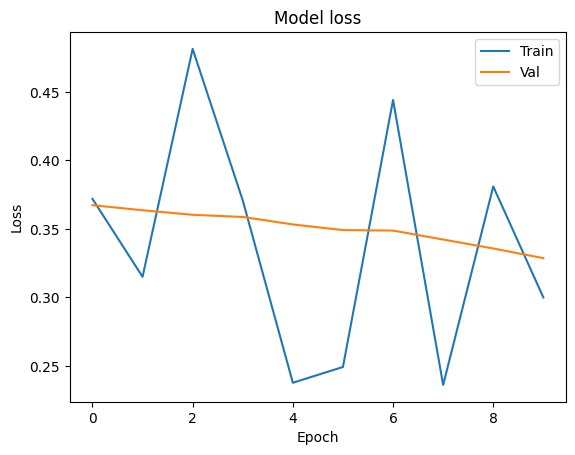

In [26]:
# Plot the change of loss during training
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

dict_keys(['train_loss', 'train_BinaryAccuracy', 'train_BinaryPrecision', 'val_loss', 'val_BinaryAccuracy', 'val_BinaryPrecision'])


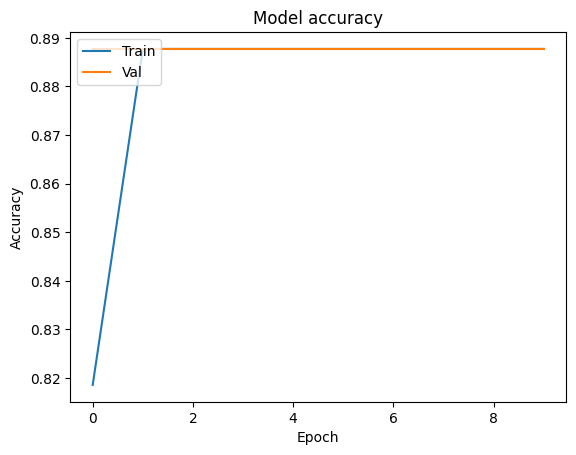

In [27]:
# Plot the change of accuracy during training
print(history.keys())
plt.plot(history['train_BinaryAccuracy'])
plt.plot(history['val_BinaryAccuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Let's call the evaluation function

In [30]:
global_metric = sl_model.evaluate(test_data, test_label, batch_size=128)

Evaluate Processing: :  88%|████████▊ | 7/8 [00:00<00:00, 66.63it/s, loss=0.117373176, BinaryAccuracy=0.8729282, BinaryPrecision=0.0]


## Compare to local model

#### Model  
Here, we use the same model structure as the one used in the split learning example, but only the model structure for Alice is used in this case. The code for defining the model is shown below.  
#### Data  
The data also use kaggle's anti-fraud data. Here, we just use Alice's data of the new bank.  
1. The total sample size was 11162, including 8929 training set and 2233 test set.  
2. The feature dimension is 4.  

In [29]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.model_selection import train_test_split


def create_model():
    model = keras.Sequential(
        [
            keras.Input(shape=4),
            layers.Dense(100, activation="relu"),
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(1, activation='sigmoid'),
        ]
    )
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=["accuracy", tf.keras.metrics.AUC()],
    )
    return model


single_model = create_model()

Data process

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
single_part_data = alice_data.copy()

single_part_data['job'] = encoder.fit_transform(alice_data['job'])
single_part_data['marital'] = encoder.fit_transform(alice_data['marital'])
single_part_data['education'] = encoder.fit_transform(alice_data['education'])
single_part_data['y'] = encoder.fit_transform(alice_data['y'])

In [31]:
y = single_part_data['y']
alice_data = single_part_data.drop(columns=['y'], inplace=False)

In [32]:
scaler = MinMaxScaler()
alice_data = scaler.fit_transform(alice_data)

In [33]:
train_data, test_data = train_test_split(
    alice_data, train_size=0.8, random_state=random_state
)
train_label, test_label = train_test_split(y, train_size=0.8, random_state=random_state)

In [34]:
alice_data.shape

(4521, 4)

In [35]:
single_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    batch_size=128,
    epochs=10,
    shuffle=False,
)

Epoch 1/10
29/29 [==============================] - 1s 16ms/step - loss: 0.5262 - accuracy: 0.8117 - auc_3: 0.4541 - val_loss: 0.3993 - val_accuracy: 0.8729 - val_auc_3: 0.4250
Epoch 2/10
29/29 [==============================] - 0s 6ms/step - loss: 0.3705 - accuracy: 0.8877 - auc_3: 0.4579 - val_loss: 0.3963 - val_accuracy: 0.8729 - val_auc_3: 0.4202
Epoch 3/10
29/29 [==============================] - 0s 6ms/step - loss: 0.3656 - accuracy: 0.8877 - auc_3: 0.4375 - val_loss: 0.3928 - val_accuracy: 0.8729 - val_auc_3: 0.4218
Epoch 4/10
29/29 [==============================] - 0s 6ms/step - loss: 0.3610 - accuracy: 0.8877 - auc_3: 0.4461 - val_loss: 0.3899 - val_accuracy: 0.8729 - val_auc_3: 0.4263
Epoch 5/10
29/29 [==============================] - 0s 6ms/step - loss: 0.3595 - accuracy: 0.8877 - auc_3: 0.4520 - val_loss: 0.3876 - val_accuracy: 0.8729 - val_auc_3: 0.4432
Epoch 6/10
29/29 [==============================] - 0s 6ms/step - loss: 0.3579 - accuracy: 0.8877 - auc_3: 0.4644 - val

In [36]:
single_model.evaluate(test_data, test_label, batch_size=128)

8/8 [==============================] - 0s 3ms/step - loss: 0.3791 - accuracy: 0.8729 - auc_3: 0.5568


[0.37905651330947876, 0.8729282021522522, 0.5568134188652039]

### Summary
The above two experiments simulate a typical vertical scene training problem. Alice and Bob have the same sample group, but each side has only a part of the features. If Alice only uses her own data to train the model, an accuracy of **0.872**, AUC **0.53** model can be obtained. However, if Bob's data are combined, a model with an accuracy of **0.875**  and AUC **0.885** can be obtained.

## Conclusion

* This tutorial introduces what is split learning and how to do it in secretFlow.  
* It can be seen from the experimental data that split learning has significant advantages in expanding sample dimension and improving model effect through joint multi-party training.
* This tutorial uses plaintext aggregation to demonstrate, without considering the leakage problem of hidden layer. Secretflow provides AggLayer to avoid the leakage problem of hidden layer plaintext transmission through MPC,TEE,HE, and DP. If you are interested, please refer to relevant documents.
* Next, you may want to try different data sets, you need to vertically shard the data first and then follow the flow of this tutorial.
